In [5]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from pathlib import Path

import os
import zarr
import h5py
import dotenv
import scipy.ndimage
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from tqdm import tqdm
dotenv.load_dotenv()

from experiments.gradcam_mean import average, zoom_heatmap

### Volume

In [26]:
DATA = Path(os.getenv('DATA'))
CONFIG = Path(os.getenv('CONFIG'))
out_dir = DATA/'nako/processed/volume'
cfg = OmegaConf.load(str(CONFIG/'volume/config.yaml'))
store = zarr.DirectoryStore(str(out_dir/'maps.zarr'))
info = pd.read_csv(cfg.dataset.info).astype({'key': str, 'age': np.float64})
h5_path = cfg.dataset.data
volume_predictions = pd.read_feather(DATA/'nako/processed/volume/predictions.feather').astype({'key': str})
df = info.join(volume_predictions.set_index('key'), on='key', how='inner')
with h5py.File(h5_path, 'r') as hf:
    keys = list(hf['image'])
    affine = hf['image'][keys[0]].attrs['affine']
    print(affine)

[[   1.5    0.     0.   -76. ]
 [   0.     1.5    0.  -111. ]
 [   0.     0.     1.5  -72. ]
 [   0.     0.     0.     1. ]]


In [17]:
hmap_average_mean = {'aa': None, 'am': None, 'af': None,
                     'ym': None, 'mm': None, 'om': None, 
                     'yf': None, 'mf': None, 'of': None}
hmap_mean_zoomed = {'aa': None, 'am': None, 'af': None,
                    'ym': None, 'mm': None, 'om': None, 
                    'yf': None, 'mf': None, 'of': None}
img = {'aa': None, 'am': None, 'af': None,
       'ym': None, 'mm': None, 'om': None, 
       'yf': None, 'mf': None, 'of': None}
with zarr.open(store=store, mode='a') as zf:
    for cat in list(img):
        img[cat] = zf[f'average/image/{cat}'][:]
        hmap_average_mean[cat] = zf[f'average/heatmap_mean/{cat}'][:]
        hmap_mean_zoomed[cat] = zoom_heatmap(hmap_average_mean[cat], img[cat].shape, order=3)

In [33]:
for c in list(img):
    nii = nib.Nifti1Image(img[c], affine)
    nib.save(nii, DATA/f'nako/processed/volume/export/img_{c}.nii.gz')
    nii = nib.Nifti1Image(hmap_mean_zoomed[c], affine)
    nib.save(nii, DATA/f'nako/processed/volume/export/hmap_mean_zoomed_{c}.nii.gz')

aa


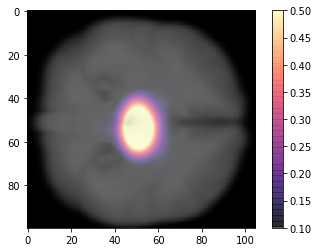

In [21]:
c = list(img)[0]
print(c)
plt.imshow(img[c].max(axis=1), cmap='gray')
hmap = hmap_mean_zoomed[c].max(axis=1)
plt.imshow(hmap, cmap='magma', alpha=0.6, vmin=0.1, vmax=0.5)
plt.colorbar()

In [22]:
img[c].shape

(100, 125, 105)

In [7]:
import nibabel as nib
mni_1mm = nib.load('/home/raheppt1/tools/FSL/data/standard/MNI152_T1_1mm_brain.nii.gz')
cropped_data = mni_1mm.get_fdata()[slice(15,170), slice(15,200), slice(0,155)]
mni_1mm_cropped = nib.Nifti1Image(cropped_data, mni_1mm.affine)
nib.save(mni_1mm_cropped, '/mnt/qdata/raheppt1/data/brainage/nako/processed/mni/cropped_MNI152_T1_1mm_brain.nii.gz')

#### Patchwise

In [39]:
DATA = Path(os.getenv('DATA'))
CONFIG = Path(os.getenv('CONFIG'))
out_dir = DATA/'nako/processed/patchwise'
cfg = OmegaConf.load(str(CONFIG/'volume/config.yaml'))
store = zarr.DirectoryStore(str(out_dir/'patches.zarr'))
position = np.load(CONFIG/'patchwise/patch_positions.npy')
info = pd.read_csv(cfg.dataset.info).astype({'key': str, 'age': np.float64})
position_predictions = pd.read_feather(DATA/'nako/processed/patchwise/predictions_pos.feather').astype({'key': str})
df_pos = info.join(volume_predictions.set_index('key'), on='key', how='inner')

In [41]:
import nibabel as nib
mni_brain = nib.load('/home/raheppt1/tools/FSL/data/standard/MNI152_T1_1mm_brain.nii.gz')
affine = mni_brain.affine
mni_brain = mni_brain.get_fdata()[(slice(15,170), slice(15,200), slice(0,155))]
mni_brain.shape


(155, 185, 155)

In [37]:
hmap_average_mean = {'aa': None, 'am': None, 'af': None,
                     'ym': None, 'mm': None, 'om': None, 
                     'yf': None, 'mf': None, 'of': None}
hmap_mean_zoomed = {'aa': None, 'am': None, 'af': None,
                    'ym': None, 'mm': None, 'om': None, 
                    'yf': None, 'mf': None, 'of': None}
img = {'aa': None, 'am': None, 'af': None,
       'ym': None, 'mm': None, 'om': None, 
       'yf': None, 'mf': None, 'of': None}
with zarr.open(store=store, mode='a') as zf:
    for cat in list(img):
        img[cat] = zf[f'average/image/{cat}'][:]
        hmap_average_mean[cat] = zf[f'average/heatmap_mean/{cat}'][:]
        hmap_mean_zoomed[cat] = zoom_heatmap(hmap_average_mean[cat], img[cat].shape, order=3)

In [49]:
for c in list(img):
    embedding = np.zeros([155, 185, 155])
    for pos in range(6):
        embedding[position[pos, 0]-32: position[pos, 0]+32, 
                position[pos, 1]-32: position[pos, 1]+32,
                position[pos, 2]-32: position[pos, 2]+32] = img[c][pos, ...]
    nii = nib.Nifti1Image(embedding, affine)
    nib.save(nii, DATA/f'nako/processed/patchwise/export/img_{c}.nii.gz')
    
    embedding = np.zeros([155, 185, 155])
    for pos in range(6):
        hmap = hmap_mean_zoomed[c][pos, ...]
        embedding[position[pos, 0]-32: position[pos, 0]+32, 
                position[pos, 1]-32: position[pos, 1]+32,
                position[pos, 2]-32: position[pos, 2]+32] = hmap
    nii = nib.Nifti1Image(embedding, affine)
    nib.save(nii, DATA/f'nako/processed/patchwise/export/hmap_mean_zoomed_{c}.nii.gz')

aa


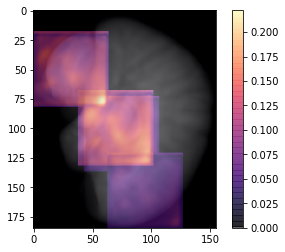

In [46]:
print(c)
plt.imshow(mni_brain.mean(axis=0), cmap='gray')
plt.imshow(embedding.mean(axis=0), cmap='magma', alpha=0.6, vmin=0)
plt.colorbar()

### Visualization

In [12]:
with zarr.open(store=store, mode='a') as zf:
    keys = list(zf['images'])

In [ ]:
hmap_mean_zoomed = zoom_heatmap(hmap_average_mean, img.shape, order=3)
hmap_sigma_zoomed = zoom_heatmap(hmap_average_sigma, img.shape, order=3)

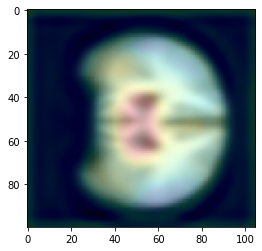

In [122]:
plt.imshow(image_average[:,90,:], cmap='gray')
plt.imshow(hmap_mean_zoomed[:,90,:], alpha=0.2, cmap='jet')

In [49]:
image_mean = np.load(out_dir/'image_mean.npy')
heatmap_zoomed_mean = np.load(out_dir/'heatmap_zoomed_mean.npy')
heatmap_zoomed_sigma = np.load(out_dir/'heatmap_zoomed_sigma.npy')

In [51]:
import nibabel as nib
affine = [[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,0]]
nifti_img = nib.Nifti1Image(image_mean, affine)
nib.save(nifti_img, out_dir/'image_mean.nii.gz')
nifti_img = nib.Nifti1Image(heatmap_zoomed_mean, affine)
nib.save(nifti_img, out_dir/'heatmap_zoomed_mean.nii.gz')
nifti_img = nib.Nifti1Image(np.log(heatmap_zoomed_mean), affine)
nib.save(nifti_img, out_dir/'heatmap_zoomed_mean_log.nii.gz')
nifti_img = nib.Nifti1Image(heatmap_zoomed_sigma, affine)
nib.save(nifti_img, out_dir/'heatmap_zoomed_sigma.nii.gz')

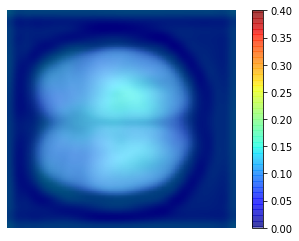

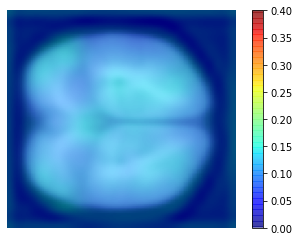

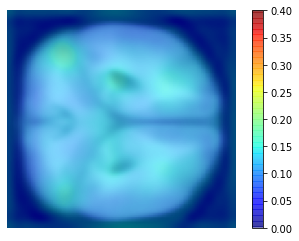

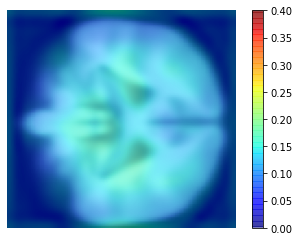

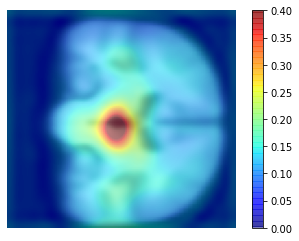

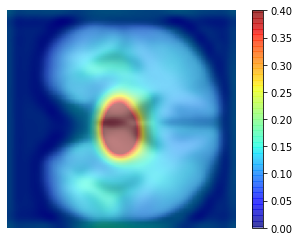

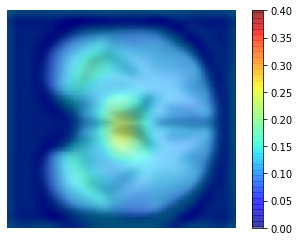

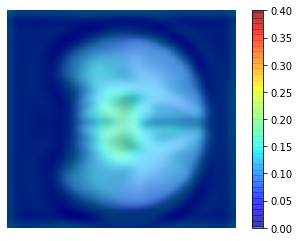

In [124]:
plt.close('all')
for slice in np.arange(20,100,10):
    plt.imshow(image_average[:,slice,:], cmap='bone')
    plt.imshow(hmap_mean_zoomed[:,slice,:], alpha=0.5, vmin=0.0, vmax=0.4, cmap='jet')
    plt.colorbar()
    plt.axis('off')
    plt.show()

In [11]:
DATA = Path(os.getenv('DATA'))
CONFIG = Path(os.getenv('CONFIG'))
out_dir = DATA/'nako/processed/patchwise'
cfg = OmegaConf.load(str(CONFIG/'volume/config.yaml'))
store = zarr.DirectoryStore(str(out_dir/'patches.zarr'))
info = pd.read_csv(cfg.dataset.info).astype({'key': str, 'age': np.float64})
position_predictions = pd.read_feather(DATA/'nako/processed/patchwise/predictions_pos.feather').astype({'key': str})
df_pos = info.join(volume_predictions.set_index('key'), on='key', how='inner')

NameError: name 'volume_predictions' is not defined

In [133]:
with zarr.open(store=store, mode='r') as zf:
    print(list(zf))
    img = zf['images'][key][:].astype(np.float32)
    hmap_mean = zf['heatmaps_mean'][key][:].astype(np.float32) 

['heatmaps_mean', 'heatmaps_sigma', 'images']


In [26]:
import os
from pathlib import Path

import zarr
import h5py
import dotenv
import numpy as np
import nibabel as nib
import pandas as pd 
from omegaconf import OmegaConf
from tqdm import tqdm
dotenv.load_dotenv()

DATA = Path(os.getenv('DATA'))
CONFIG = Path(os.getenv('CONFIG'))
total = 0
mni_brain = nib.load(DATA/'nako/processed/mni/cropped_MNI152_T1_1mm_brain.nii.gz')
affine = mni_brain.affine
cfg = OmegaConf.load(str(CONFIG/'volume/config.yaml'))
map_diff = np.zeros([155, 185, 155])
map_sigma = np.zeros([155, 185, 155])
info = pd.read_csv(cfg.dataset.info).astype({'key': str, 'age': np.float64})
info = info.set_index('key')
with zarr.open(str(DATA/'nako/processed/patchwise/maps.zarr')) as zf:
    keys = list(zf['agemaps'])
    for key in tqdm(keys[:100]):
        age = info.loc[key]['age']
        map_diff = map_diff + zf['agemaps'][key][0] - age
        map_sigma = map_sigma + zf['agemaps'][key][1]
        total = total + 1
map_diff = map_diff/total
map_sigma = map_sigma/total
nii = nib.Nifti1Image(map_diff, affine)
nib.save(nii, str(DATA/'nako/processed/patchwise/export/map_diff_average.nii.gz'))
nii = nib.Nifti1Image(map_sigma, affine)
nib.save(nii, str(DATA/'nako/processed/patchwise/export/map_sigma_average.nii.gz'))

100%|██████████| 100/100 [00:21<00:00,  4.71it/s]


In [52]:
dir = Path('/mnt/qdata/raheppt1/data/brainage/nako/interim/vbm/test4')
files = sorted(list(dir.glob('*nii')))
keys = [f.stem[:6] for f in files]
tiv = Path('/mnt/qdata/raheppt1/data/brainage/nako/interim/vbm/test4/report/TIV_test4.txt')
tiv = np.array([float(l.split('\t')[0]) for l in tiv.open('r').readlines()])

In [82]:
info = pd.read_csv('/mnt/qdata/raheppt1/data/brainage/nako/interim/nako_age_labels.csv').astype({'key': str, 'age': np.float64})
info = info.set_index('key')
metadata = pd.merge(info.loc[keys]['age'], pd.DataFrame.from_dict({'key': keys, 'tiv': tiv}), how='inner', on='key')
metadata.set_index('key')

,age,tiv
key,,
109342,59.0,1538.78
109343,52.0,1545.23
109344,34.0,1498.56
109345,66.0,1473.99
109346,64.0,1501.42
...,...,...
111676,48.0,1627.75
111677,35.0,1730.78
111678,36.0,1704.10


In [71]:
dir = Path('/mnt/qdata/raheppt1/data/brainage/nako/interim/vbm/test4/mri')
proc_files = sorted(list(dir.glob('mwp1*nii')))
proc_keys = [f.stem[4:10] for f in proc_files]

In [81]:
proc_metadata = metadata.set_index('key').loc[proc_keys]
len(proc_metadata)

2136

In [84]:
np.array(proc_metadata['age'].tolist())

array([59., 52., 34., ..., 36., 33., 65.])

In [88]:
import scipy.io
scipy.io.savemat('/mnt/qdata/raheppt1/data/brainage/nako/interim/vbm/test4/report/meta.mat',
                 {'age': np.array(proc_metadata['age'].tolist()),
                  'tiv': np.array(proc_metadata['tiv'].tolist())})